In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

### setting the different directories 

# on the server (linux):
# where to find the images:
home_dir = '/home/rick/Documents/HannahZ'
# folder where to save code and so on
code_dir = home_dir + '/Code'
# where to save the final models
model_dir = code_dir + '/Final_models'
# where to save the logs for visualization in TensorBoard
log_dir = code_dir + '/logs'
# where to save the weights
new_weight_dir = code_dir + '/new_weights'


# on my computer (windows):
# where to find the images:
#home_dir = '\\Users\\ThinkPad User\\Google Drive\\DeepSolaris'
# folder where to save code and so on
#code_dir = '\\Users\\ThinkPad User\\Google Drive\\Master_thesis_H_Z_DL&NN\\Coding'
# where to save the final models
#model_dir = code_dir + '\\Final_models_saved'
# where to save the logs for visualization in TensorBoard
#log_dir = code_dir + '\\logs'
import os
os.chdir(home_dir)

In [3]:
modelname = 'IncV3'

In [4]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.engine import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape 

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy


from random import randrange
from random import seed
from random import sample
import tensorflow as tf


import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from keras.preprocessing import image
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import keras
from keras.callbacks import Callback
from keras.applications.inception_v3 import InceptionV3


os.chdir(code_dir)

from Learning_rate_scheduler import LrReducer
from CyclicLR import CyclicLR

Using TensorFlow backend.


In [5]:
### Helper metrics functions

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
    
    
def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score
def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

no_of_epochs = 0

### check if data are in the right format
K.image_data_format() == 'channels_last'

os.chdir(home_dir)
train_images = np.load('training_images_AcMüDüHo.npy')
valid_images = np.load('validation_images_AcMüDüHo.npy')
test_images = np.load('test_images_AcMüDüHo.npy')
train_labels = np.load('training_labels_AcMüDüHo.npy')
valid_labels = np.load('validation_labels_AcMüDüHo.npy')
test_labels = np.load('test_labels_AcMüDüHo.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels)))
print("- Validation-set:\t{}".format(len(valid_labels)))
print("- Test-set:\t\t{}".format(len(test_labels)))

Size of:
- Training-set:		3357
- Validation-set:	374
- Test-set:		934


In [6]:
# choose training specifications (None or 'imagenet')
weights = 'imagenet'
#tf.reset_default_graph()

# importing the currently used model
os.chdir(code_dir)

### create the base pre-trained model
# usually takes around 30 seconds
Model_base = InceptionV3(weights = weights, include_top=False, )
# find out how many layers exist to find right number of trainable layers
len(Model_base.layers)

311

In [7]:
# choose layers for split
# for i, layer in enumerate(Model_base.layers):
#      if ('pool' in layer.name):
#         print(i, layer.name)

In [8]:
# choose trainable layers as 'Frozen' or 'All' or some number
trainable_layers = 'All'
# otherwise trainable_layers = x
# add a global spatial average pooling layer to the pretrained model to 
# finish its compilation
def compileModel(trainable_layers = 'Frozen'):
    global Final_model
    x = Model_base.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    Final_model = Model(inputs=Model_base.input, outputs=preds)
    if (trainable_layers == 'Frozen'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = False
    elif (trainable_layers == 'All'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = True
    else:
        for layer in Model_base.layers[:trainable_layers]:
            layer.trainable = False
        for layer in Model_base.layers[trainable_layers:]:  
            layer.trainable = True
    Final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy', precision, recall, fmeasure])
# calculating the stepsize
(3357/64)*8

419.625

In [8]:
###################### first training stage ###################################
batch_size = 64
step_size = 420
base_lr = 0.00001
max_lr = 0.001
epochs = 48
mode = 'triangular'
def train_Model(verbose =1, times = 2, epochs = epochs, base_lr = base_lr, max_lr= max_lr, mode = mode, 
                stepsize = step_size, batch_size = batch_size, use_tensorboard = False):
    start_time = time()   
    global h
    global no_of_epochs
    global name
    date = str(datetime.now().date())
    # logdir in linux:
    logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + '_base-' 
              + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    # logdir in windows:
    ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
    #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
            + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + ', *' + str(times))
    print(' - Model specifics:\t{}'.format(name))
    clr = CyclicLR(base_lr = base_lr, max_lr=max_lr,
                        step_size= stepsize, mode = mode)
    tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                         write_graph=False, write_images=False)
    if (use_tensorboard == True):
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [tbCallBack, clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
    else:
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
    no_of_epochs = no_of_epochs + epochs
    h = []
    h = clr.history
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')
print(weights)
print(trainable_layers)

imagenet
All


 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.001, *5
Time usage: 0:02:00 minutes
934/934 [==============================] - 1s 774us/step
- Training accuracy:	0.6881
- Validation accuracy:	0.6283
- Test accuracy:	0.6617


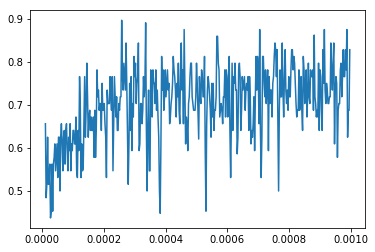

In [9]:
compileModel()
train_Model(times = 5, use_tensorboard = True, verbose = 0)
train_acc = round(Final_model.evaluate(train_images, train_labels, 128)[1],4)
valid_acc = round(Final_model.evaluate(valid_images, valid_labels, 128)[1],4)
test_acc = round(Final_model.evaluate(test_images, test_labels, 128)[1],4)

print("- Training accuracy:\t{}".format(train_acc))
print("- Validation accuracy:\t{}".format(valid_acc))
print("- Test accuracy:\t{}".format(test_acc))

%matplotlib inline
lr = h['lr'][:step_size]
acc = h['acc'][:step_size]
plt.plot(lr, acc)

In [10]:
### choose your learning rates now! The one where the accuracy starts to rise as base_lr and the one where it stops
### growing/ starts to tumble as max_lr
baseLRS = [0.000001, 0.00001, 0.00005]
maxLRS = [0.0002, 0.0004, 0.0006]

In [11]:
# experiment with different learning rate ranges
def learning_rate_finder(rep = 5, baseLRS = baseLRS, maxLRS = maxLRS):
    start_time = time() 
    global test_acc_list
    global valid_acc_list
    global train_acc_list
    global test_loss_list
    global valid_loss_list
    global train_loss_list
    global test_prec_list
    global valid_prec_list
    global train_prec_list
    global test_rec_list
    global valid_rec_list
    global train_rec_list
    global model_details
    model_details = []
    test_acc_list = []
    valid_acc_list = []
    train_acc_list = []
    test_loss_list = []
    valid_loss_list = []
    train_loss_list = []
    test_prec_list = []
    valid_prec_list = []
    train_prec_list = []
    test_rec_list = []
    valid_rec_list = []
    train_rec_list = []
    for blr in baseLRS:
        print('NEXT LEARNINGRATE: {}'.format(blr))
        for mlr in maxLRS:
            print('Models with base lr = ' + str(blr) + ' and max lr = ' + str(mlr))
            for i in range(rep):
                    compileModel()
                    times = i
                    if (i == 0):
                        train_Model(times = times, epochs = epochs, base_lr = blr, max_lr = mlr, verbose = 0, 
                                    use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = epochs, base_lr = blr, max_lr = mlr, verbose = 0)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_list.append(test_acc)
                    valid_acc_list.append(valid_acc)
                    train_acc_list.append(train_acc)
                    test_loss_list.append(test_loss)
                    valid_loss_list.append(valid_loss)
                    train_loss_list.append(train_loss)
                    test_prec_list.append(test_prec)
                    valid_prec_list.append(valid_prec)
                    train_prec_list.append(train_prec)
                    test_rec_list.append(test_rec)
                    valid_rec_list.append(valid_rec)
                    train_rec_list.append(train_rec)
                    model_details.append(name)
            print("- Training accuracies:\t{}".format([round(el,4) for el in train_acc_list]))
            print("- Validation accuracies:\t{}".format([round(el,4) for el in valid_acc_list]))
            print("- Testing accuracies:\t{}".format([round(el,4) for el in test_acc_list]))
            print('')
            print('')
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')        

NEXT LEARNINGRATE: 1e-06
Models with base lr = 1e-06 and max lr = 0.0002
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-06, max-lr 0.0002, *0
Time usage: 0:01:56 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-06, max-lr 0.0002, *1
Time usage: 0:01:53 minutes
934/934 [==============================] - 1s 950us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-06, max-lr 0.0002, *2
Time usage: 0:01:55 minutes
934/934 [==============================] - 1s 947us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-06, max-lr 0.0002, *3
Time usage: 0:01:52 minutes
934/934 [==============================] - 1s 958us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-06, max-lr 0.0002, *4
Time usage: 0:01:55 minutes
934/934 [==============================] - 1s 

Time usage: 0:01:55 minutes
934/934 [==============================] - 1s 972us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0004, *2
Time usage: 0:01:54 minutes
934/934 [==============================] - 1s 919us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0004, *3
Time usage: 0:01:53 minutes
934/934 [==============================] - 1s 943us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0004, *4
Time usage: 0:01:56 minutes
934/934 [==============================] - 1s 932us/step
- Training accuracies:	[0.6768, 0.6595, 0.6807, 0.686, 0.6816, 0.6726, 0.692, 0.6813, 0.6744, 0.6768, 0.6968, 0.6899, 0.6798, 0.7084, 0.6836, 0.706, 0.6965, 0.6839, 0.6896, 0.6881, 0.6842, 0.6804, 0.6556, 0.6825, 0.6637]
- Validation accuracies:	[0.6364, 0.6123, 0.6417, 0.6417, 0.6364, 0.6203, 0.6364, 0.6417, 0.6283, 0.6283, 0.6444, 0.6417, 0.6417, 

/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107544). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
934/934 [==============================] - 1s 959us/step
- Training accuracies:	[0.6768, 0.6595, 0.6807, 0.686, 0.6816, 0.6726, 0.692, 0.6813, 0.6744, 0.6768, 0.6968, 0.6899, 0.6798, 0.7084, 0.6836, 0.706, 0.6965, 0.6839, 0.6896, 0.6881, 0.6842, 0.6804, 0.6556, 0.6825, 0.6637, 0.6807, 0.6717, 0.6822, 0.6705, 0.6717, 0.6831, 0.6735, 0.6741, 0.6676, 0.6973]
- Validation accuracies:	[0.6364, 0.6123, 0.6417, 0.6417, 0.6364, 0.6203, 0.6364, 0.6417, 0.6283, 0.6283, 0.6444, 0.6417, 0.6417, 0.6497, 0.6524, 0.6658, 0.6551, 0.6471, 0.6711, 0.6524, 0.639, 0.631, 0.6096, 0.6444, 0.623, 0.6551, 0.6337, 0.6337, 0.623, 0.631, 0.6551, 0.6524, 0.6364, 0.6257, 0.6524]
- Testing accuracies:	[0.6692, 0.6552, 0.667, 0.682, 0.6788, 0.6585, 0.6788, 0.6681, 0.6756, 0.651, 0.6842, 0.6734, 0.6552, 0.6991, 0.6574, 0.6916, 0.6809, 0.6713, 0.6831, 0.6852, 0.6702, 0.6745, 0.6392, 0.6842, 0.6595, 0.6585, 0.667, 0.6627, 0.6456, 0.6552, 0.6799, 0.6702, 0.6681, 0.6585, 0.6991]


Models with 

/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101326). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
934/934 [==============================] - 1s 955us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 5e-05, max-lr 0.0006, *1
Time usage: 0:01:55 minutes
934/934 [==============================] - 1s 979us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 5e-05, max-lr 0.0006, *2
Time usage: 0:01:55 minutes
934/934 [==============================] - ETA:  - 1s 979us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 5e-05, max-lr 0.0006, *3
Time usage: 0:01:53 minutes
934/934 [==============================] - 1s 975us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 5e-05, max-lr 0.0006, *4
Time usage: 0:01:54 minutes
934/934 [==============================] - 1s 938us/step
- Training accuracies:	[0.6768, 0.6595, 0.6807, 0.686, 0.6816, 0.6726, 0.692, 0.6813, 0.6744, 0.6768, 0.6968, 0.6899, 0.6798, 0.7084, 0.6836, 0.706, 0.6965

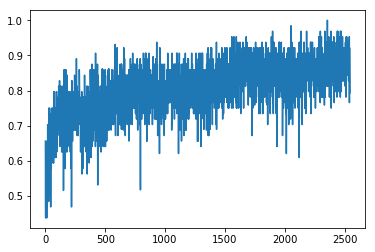

In [12]:
# usual training time: 2h
learning_rate_finder()
%matplotlib inline
acc = h['acc']
plt.plot(acc)

In [13]:
titel = model_details[0][:47]
mean_test_acc = []
mean_valid_acc = []
mean_train_acc = []
mean_test_loss = []
mean_valid_loss = []
mean_train_loss = []
mean_test_prec = []
mean_valid_prec = []
mean_train_prec = []
mean_test_rec = []
mean_valid_rec = []
mean_train_rec = []
model_list = []
a = len(test_acc_list)
for i in range(9):
    tals = test_acc_list[i:(i+1)*5]
    vals = valid_acc_list[i:(i+1)*5]
    rals = train_acc_list[i:(i+1)*5]
    tlls = test_loss_list[i:(i+1)*5]
    vlls = valid_loss_list[i:(i+1)*5]
    rlls = train_loss_list[i:(i+1)*5]
    tpls = test_prec_list[i:(i+1)*5]
    vpls = valid_prec_list[i:(i+1)*5]
    rpls = train_prec_list[i:(i+1)*5]
    trls = test_rec_list[i:(i+1)*5]
    vrls = valid_rec_list[i:(i+1)*5]
    rrls = train_rec_list[i:(i+1)*5]
    tmean = round(sum(tals)/len(tals),4)
    vmean = round(sum(vals)/len(vals),4)
    rmean = round(sum(rals)/len(rals),4)
    ltmean = round(sum(tlls)/len(tals),4)
    lvmean = round(sum(vlls)/len(vals),4)
    lrmean = round(sum(rlls)/len(rals),4)
    ptmean = round(sum(tpls)/len(tals),4)
    pvmean = round(sum(vpls)/len(vals),4)
    prmean = round(sum(rpls)/len(rals),4)
    rtmean = round(sum(trls)/len(tals),4)
    rvmean = round(sum(vrls)/len(vals),4)
    rrmean = round(sum(rrls)/len(rals),4)
    mean_test_acc.append(tmean)
    mean_valid_acc.append(vmean)
    mean_train_acc.append(rmean)
    mean_test_loss.append(ltmean)
    mean_valid_loss.append(lvmean)
    mean_train_loss.append(lrmean)
    mean_test_prec.append(ptmean)
    mean_valid_prec.append(pvmean)
    mean_train_prec.append(prmean)
    mean_test_rec.append(rtmean)
    mean_valid_rec.append(rvmean)
    mean_train_rec.append(rrmean)
    model_list.append(model_details[i*5][49:79])
columns = ['test acc', 'valid acc', 'train acc', 'test loss', 'valid loss', 'train loss', 'test prec', \
           'valid prec', 'train prec', 'test rec', 'valid rec', 'train rec']
data = np.array((mean_test_acc, mean_valid_acc, mean_train_acc, mean_test_loss, mean_valid_loss, mean_train_loss,\
                mean_test_prec, mean_valid_prec, mean_train_prec, mean_test_rec, mean_valid_rec, mean_train_rec))
results = pd.DataFrame(data = data, columns = model_list, index = columns)
lr_overview = pd.DataFrame(data = results.transpose(), columns = columns, index = model_list)
#lr_overview
overviewSorted = lr_overview.sort_values(by=['test acc'], ascending = False)
overviewSorted

,test acc,valid acc,train acc,test loss,valid loss,train loss,test prec,valid prec,train prec,test rec,valid rec,train rec
"base-lr: 1e-05, max-lr 0.0002,",0.6750,0.6444,0.6875,1.2512,1.3230,1.1718,0.6221,0.5797,0.6226,0.9434,0.9399,0.9494
"base-lr: 1e-05, max-lr 0.0004,",0.6724,0.6409,0.6842,1.2832,1.3582,1.2045,0.6198,0.5773,0.6196,0.9461,0.9422,0.9513
"base-lr: 1e-06, max-lr 0.0006,",0.6715,0.6388,0.6849,1.3050,1.3821,1.2193,0.6189,0.5760,0.6198,0.9448,0.9393,0.9533
"base-lr: 5e-05, max-lr 0.0002,",0.6706,0.6414,0.6823,1.3096,1.3834,1.2273,0.6184,0.5776,0.6182,0.9455,0.9451,0.9515
"base-lr: 1e-06, max-lr 0.0002,",0.6704,0.6337,0.6769,1.2072,1.2979,1.1443,0.6181,0.5713,0.6140,0.9448,0.9512,0.9519
"base-lr: 1e-05, max-lr 0.0006,",0.6692,0.6400,0.6825,1.3251,1.3981,1.2412,0.6172,0.5769,0.6182,0.9459,0.9425,0.9522
"base-lr: 5e-05, max-lr 0.0004,",0.6685,0.6404,0.6813,1.3224,1.3942,1.2390,0.6168,0.5769,0.6172,0.9450,0.9447,0.9520
"base-lr: 1e-06, max-lr 0.0004,",0.6683,0.6319,0.6783,1.2551,1.3403,1.1824,0.6162,0.5707,0.6146,0.9460,0.9455,0.9539
"base-lr: 5e-05, max-lr 0.0006,",0.6664,0.6391,0.6798,1.3580,1.4330,1.2702,0.6150,0.5762,0.6159,0.9454,0.9466,0.9533


In [14]:
blr = 0.00001
mlr = 0.0002

In [9]:
os.chdir(code_dir + '/Excel')
savename = ('AfterTuningLR_modelOverview_' + str(modelname) + '_bs-' + str(batch_size) + '_' + str(mode) + '_sz-' 
            + str(step_size) + '_' + str(weights) + '_' + str(trainable_layers) + '_' + str(epochs) + 'epochs')
savename

NameError: name 'batch_size' is not defined

In [16]:
overviewSorted.to_csv(savename)

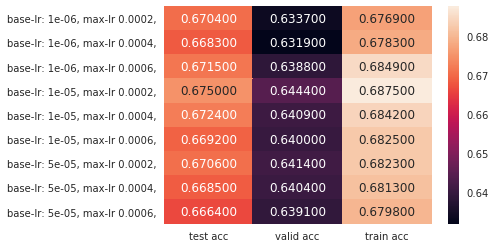

In [17]:
import seaborn as sns
sns.set()
heatmap = sns.heatmap(results.iloc[:3,:].transpose(), annot=True, fmt = 'f')

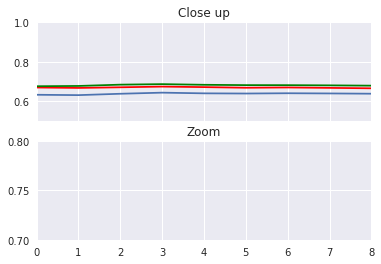

In [18]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='row')
ax1.plot(mean_test_acc, color = 'r')
ax1.axis([0, 8, 0.5, 1])
ax1.set_title('Close up')
ax1.plot(mean_valid_acc)
ax1.plot(mean_train_acc, color = 'g')
ax2.set_title('Zoom')
ax2.plot(mean_test_acc, color = 'r')
ax2.axis([0, 8, 0.7, 0.8])
ax2.plot(mean_valid_acc)
ax2.plot(mean_train_acc, color = 'g')

In [19]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [20]:
stepsizes128 = [157, 210, 262]
stepsizes64 = [315, 420,525]
batch_sizes = [64, 128]
modes = ['triangular', 'triangular2']
rep = 1

In [21]:
def hp_tuner(base_lr = blr, max_lr = mlr, rep = 5):
    start_time = time()  
    global test_acc_l
    global valid_acc_l
    global train_acc_l
    global test_loss_l
    global valid_loss_l
    global train_loss_l
    global test_prec_l
    global valid_prec_l
    global train_prec_l
    global test_rec_l
    global valid_rec_l
    global train_rec_l
    global model_det
    model_det = []
    test_acc_l = []
    valid_acc_l = []
    train_acc_l = []
    test_loss_l = []
    valid_loss_l = []
    train_loss_l = []
    test_prec_l = []
    valid_prec_l = []
    train_prec_l = []
    test_rec_l = []
    valid_rec_l = []
    train_rec_l = []
    for bs in batch_sizes:
        if (bs == 64):
            stepsizes = stepsizes64
        if (bs ==128):
            stepsizes = stepsizes128
        for sz in stepsizes: 
            for md in modes:
                i = 0
                mid_time = time()
                while (i < rep):
                    compileModel()
                    times = i
                    if (i == 0):
                        train_Model(times = times, epochs = 48, base_lr = base_lr, max_lr = max_lr, verbose = 0,
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = 48, base_lr = base_lr, max_lr = max_lr, verbose = 0, 
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = False)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_l.append(test_acc)
                    valid_acc_l.append(valid_acc)
                    train_acc_l.append(train_acc)
                    test_loss_l.append(test_loss)
                    valid_loss_l.append(valid_loss)
                    train_loss_l.append(train_loss)
                    test_prec_l.append(test_prec)
                    valid_prec_l.append(valid_prec)
                    train_prec_l.append(train_prec)
                    test_rec_l.append(test_rec)
                    valid_rec_l.append(valid_rec)
                    train_rec_l.append(train_rec)
                    model_det.append(name)
    ### training the same model for more epochs
                    if (i == 0):
                        train_Model(times = times, epochs = 48, base_lr = base_lr, max_lr = max_lr, verbose = 0,
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = 48, base_lr = base_lr, max_lr = max_lr, verbose = 0, 
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = False)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_l.append(test_acc)
                    valid_acc_l.append(valid_acc)
                    train_acc_l.append(train_acc)
                    test_loss_l.append(test_loss)
                    valid_loss_l.append(valid_loss)
                    train_loss_l.append(train_loss)
                    test_prec_l.append(test_prec)
                    valid_prec_l.append(valid_prec)
                    train_prec_l.append(train_prec)
                    test_rec_l.append(test_rec)
                    valid_rec_l.append(valid_rec)
                    train_rec_l.append(train_rec)
                    name2 = name + '_x2'
                    model_det.append(name2)
                    print(log_dir)
                    i += 1
                mid_end_time = time()
                mid_time_dif = mid_end_time - mid_time
                print('Time usage: ' + str(timedelta(seconds=int(round(mid_time_dif)))) + ' minutes')
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [22]:
# usual training time: 4:51 / 3:21 / 3:26
rep = 5
hp_tuner(rep = rep)

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:02:03 minutes
3357/3357 [==============================] - 3s 899us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:47 minutes
3357/3357 [==============================] - 3s 891us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:54 minutes
3357/3357 [==============================] - 3s 904us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:47 minutes
3357/3357 [==============================] - 3s 878us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:54 minutes
3357/3357 [====================

/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114923). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 873us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 898us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:54 minutes
3357/3357 [==============================] - 3s 869us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 896us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:22 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109128). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:03 minutes
3357/3357 [==============================] - 3s 890us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:47 minutes
3357/3357 [==============================] - 3s 877us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111719). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 878us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:47 minutes
3357/3357 [==============================] - 3s 882us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110261). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 896us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 894us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108492). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 881us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 901us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110097). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 888us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 904us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:25 minutes
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141986). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:57 minutes
3357/3357 [==============================] - 3s 882us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 885us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132865). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:57 minutes
3357/3357 [==============================] - 3s 901us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 917us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123158). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:54 minutes
3357/3357 [==============================] - 3s 882us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:47 minutes
3357/3357 [==============================] - 3s 876us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115515). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 887us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 885us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114581). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 890us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 895us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:24 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110769). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 895us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 876us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111811). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 892us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 872us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115171). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 899us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 883us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115445). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 893us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 876us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117737). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 878us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 881us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:24 minutes
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120314). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 884us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 894us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120503). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 888us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119559). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 887us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:49 minutes
3357/3357 [==============================] - 3s 885us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119684). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 882us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 893us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116666). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:55 minutes
3357/3357 [==============================] - 3s 912us/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 893us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:24 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121639). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:57 minutes
3357/3357 [==============================] - 3s 900us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 894us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.185688). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:01 minutes
3357/3357 [==============================] - 3s 911us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:51 minutes
3357/3357 [==============================] - 3s 882us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168212). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:57 minutes
3357/3357 [==============================] - 3s 893us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 900us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159561). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:57 minutes
3357/3357 [==============================] - 3s 902us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 902us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152992). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:56 minutes
3357/3357 [==============================] - 3s 894us/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:48 minutes
3357/3357 [==============================] - 3s 901us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:19:35 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140360). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 915us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 894us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134736). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 884us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 912us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.139079). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 904us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 901us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140759). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 899us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 946us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130070). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:30 minutes
3357/3357 [==============================] - 3s 923us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:21 minutes
3357/3357 [==============================] - 3s 913us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:14:42 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200660). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:34 minutes
3357/3357 [==============================] - 3s 936us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 903us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.173141). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 905us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 918us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166238). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 906us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:18 minutes
3357/3357 [==============================] - 3s 927us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154280). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:26 minutes
3357/3357 [==============================] - 3s 903us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:17 minutes
3357/3357 [==============================] - 3s 890us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144872). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:34 minutes
3357/3357 [==============================] - 3s 908us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:30 minutes
3357/3357 [==============================] - 3s 924us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:14:59 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148548). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:37 minutes
3357/3357 [==============================] - 3s 910us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:26 minutes
3357/3357 [==============================] - 3s 920us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.176596). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 911us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 934us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150550). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 937us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 921us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.151377). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 930us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 916us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153020). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 919us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:18 minutes
3357/3357 [==============================] - 3s 932us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:14:55 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143923). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:38 minutes
3357/3357 [==============================] - 3s 909us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 919us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150880). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:38 minutes
3357/3357 [==============================] - 3s 944us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:31 minutes
3357/3357 [==============================] - 3s 920us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159031). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 904us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 916us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152930). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 921us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 917us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155219). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 927us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 916us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:15:21 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157592). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 904us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:18 minutes
3357/3357 [==============================] - 3s 914us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.159599). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:27 minutes
3357/3357 [==============================] - 3s 909us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 917us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164216). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 912us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:18 minutes
3357/3357 [==============================] - 3s 902us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268741). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:30 minutes
3357/3357 [==============================] - 3s 922us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 911us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232111). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 946us/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 955us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:14:42 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *0


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180705). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:30 minutes
3357/3357 [==============================] - 3s 903us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *0
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 920us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *1


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179804). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 921us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *1
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 956us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *2


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180496). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:30 minutes
3357/3357 [==============================] - 3s 925us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *2
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 936us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *3


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182409). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:28 minutes
3357/3357 [==============================] - 3s 914us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *3
Time usage: 0:01:20 minutes
3357/3357 [==============================] - 3s 974us/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *4


/home/rick/.conda/envs/hannah_z/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188976). Check your callbacks.
  % delta_t_median)


Time usage: 0:01:29 minutes
3357/3357 [==============================] - 3s 932us/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 1e-05, max-lr 0.0002, *4
Time usage: 0:01:19 minutes
3357/3357 [==============================] - 3s 917us/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:14:48 minutes
Time usage: 3:26:03 minutes


In [23]:
rep = 5
titel = model_details[0][:47]
mean_test_a = []
mean_valid_a = []
mean_train_a = []
mean_test_l = []
mean_valid_l = []
mean_train_l = []
mean_test_p = []
mean_valid_p = []
mean_train_p = []
mean_test_r = []
mean_valid_r = []
mean_train_r = []
model_l = []
a = int(len(test_acc_l)/rep)
for i in range(a):
    tals = test_acc_l[i:(i+1)*rep]
    vals = valid_acc_l[i:(i+1)*rep]
    rals = train_acc_l[i:(i+1)*rep]
    tlls = test_loss_l[i:(i+1)*rep]
    vlls = valid_loss_l[i:(i+1)*rep]
    rlls = train_loss_l[i:(i+1)*rep]
    tpls = test_prec_l[i:(i+1)*rep]
    vpls = valid_prec_l[i:(i+1)*rep]
    rpls = train_prec_l[i:(i+1)*rep]
    trls = test_rec_l[i:(i+1)*rep]
    vrls = valid_rec_l[i:(i+1)*rep]
    rrls = train_rec_l[i:(i+1)*rep]
    tmean = round(sum(tals)/len(tals),4)
    vmean = round(sum(vals)/len(vals),4)
    rmean = round(sum(rals)/len(rals),4)
    ltmean = round(sum(tlls)/len(tals),4)
    lvmean = round(sum(vlls)/len(vals),4)
    lrmean = round(sum(rlls)/len(rals),4)
    ptmean = round(sum(tpls)/len(tals),4)
    pvmean = round(sum(vpls)/len(vals),4)
    prmean = round(sum(rpls)/len(rals),4)
    rtmean = round(sum(trls)/len(tals),4)
    rvmean = round(sum(vrls)/len(vals),4)
    rrmean = round(sum(rrls)/len(rals),4)
    mean_test_a.append(tmean)
    mean_valid_a.append(vmean)
    mean_train_a.append(rmean)
    mean_test_l.append(ltmean)
    mean_valid_l.append(lvmean)
    mean_train_l.append(lrmean)
    mean_test_p.append(ptmean)
    mean_valid_p.append(pvmean)
    mean_train_p.append(prmean)
    mean_test_r.append(rtmean)
    mean_valid_r.append(rvmean)
    mean_train_r.append(rrmean)
    if (model_det[i*rep][-2:] == 'x2'):
        model_l.append(model_det[i*rep][6:49] + ' ' + model_det[i*rep][-2:])
    else:
        model_l.append(model_det[i*rep][6:49])

In [24]:
print(model_det[8][6:49])
print(model_det[0][-2:])

size: 64, mode: triangular, stepsize: 315, 
*0


In [25]:
savename2 = ('AfterTuningHP_modelOverview_' + str(modelname) + '_bs-'+ str(batch_size) + '_' + str(mode) + '_sz-' 
             + str(step_size) + '_' + str(weights) + '_' + str(trainable_layers) + '_' + str(epochs) + 'epochs')
savename2

'AfterTuningHP_modelOverview_IncV3_bs-64_triangular_sz-420_imagenet_All_48epochs'

In [26]:
cols = ['test acc', 'valid acc', 'train acc', 'test loss', 'valid loss', 'train loss', 'test prec', \
           'valid prec', 'train prec', 'test rec', 'valid rec', 'train rec']
data2 = np.array((mean_test_a, mean_valid_a, mean_train_a, mean_test_l, mean_valid_l, mean_train_l,\
                mean_test_p, mean_valid_p, mean_train_p, mean_test_r, mean_valid_r, mean_train_r))
results2 = pd.DataFrame(data = data2, columns = model_l, index = cols)
hp_overview = pd.DataFrame(data = results2.transpose(), columns = cols, index = model_l)
hpOverviewSorted = hp_overview.sort_values(by=['test acc'], ascending = False)
hpOverviewSorted
os.chdir(code_dir + '/Excel')
hpOverviewSorted.to_csv(savename2)

,test acc,valid acc,train acc,test loss,valid loss,train loss,test prec,valid prec,train prec,test rec,valid rec,train rec
"size: 64, mode: triangular2, stepsize: 315, x2",0.6762,0.6469,0.6835,1.1868,1.2604,1.1241,0.6226,0.5804,0.6194,0.9463,0.9480,0.9506
"size: 64, mode: triangular2, stepsize: 315,",0.6760,0.6458,0.6822,1.1948,1.2704,1.1372,0.6226,0.5800,0.6183,0.9461,0.9479,0.9511
"size: 64, mode: triangular, stepsize: 420,",0.6752,0.6467,0.6835,1.2001,1.2637,1.1327,0.6215,0.5800,0.6191,0.9469,0.9506,0.9522
"size: 64, mode: triangular2, stepsize: 420,",0.6738,0.6444,0.6822,1.2103,1.2756,1.1444,0.6204,0.5785,0.6179,0.9465,0.9508,0.9525
"size: 64, mode: triangular2, stepsize: 420, x2",0.6735,0.6445,0.6822,1.2067,1.2715,1.1411,0.6202,0.5786,0.6181,0.9463,0.9515,0.9521
"size: 64, mode: triangular2, stepsize: 525,",0.6734,0.6441,0.6822,1.2068,1.2746,1.1407,0.6210,0.5791,0.6188,0.9446,0.9476,0.9496
"size: 64, mode: triangular, stepsize: 420, x2",0.6728,0.6434,0.6820,1.2215,1.2855,1.1540,0.6195,0.5778,0.6177,0.9471,0.9493,0.9529
"size: 64, mode: triangular, stepsize: 525, x2",0.6722,0.6435,0.6816,1.2143,1.2789,1.1473,0.6200,0.5786,0.6183,0.9441,0.9477,0.9499
"size: 64, mode: triangular, stepsize: 525,",0.6721,0.6434,0.6804,1.2159,1.2792,1.1492,0.6193,0.5781,0.6168,0.9468,0.9508,0.9518
"size: 64, mode: triangular2, stepsize: 525, x2",0.6717,0.6430,0.6813,1.2167,1.2848,1.1498,0.6196,0.5783,0.6178,0.9452,0.9489,0.9509


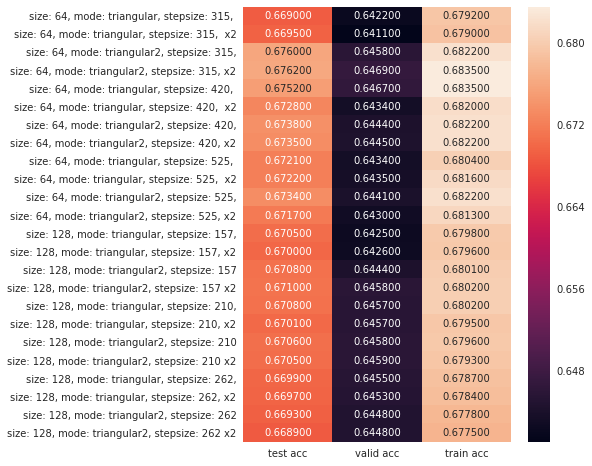

In [27]:
%matplotlib inline
plt.figure(figsize=(6, 8))

sns.heatmap(hp_overview.iloc[:,:3], annot=True,  fmt = 'f')

[0, 9, 0.5, 1]

[0, 9, 0.73, 0.79]

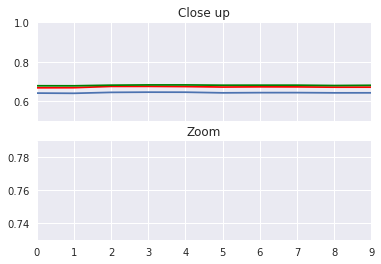

In [28]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='row')
ax1.plot(mean_test_a, color = 'r')
ax1.axis([0, 9, 0.5, 1])
ax1.set_title('Close up')
ax1.plot(mean_valid_a)
ax1.plot(mean_train_a, color = 'g')
ax2.set_title('Zoom')
ax2.plot(mean_test_a, color = 'r')
ax2.axis([0, 9, 0.73, 0.79])
ax2.plot(mean_valid_a)
ax2.plot(mean_train_a, color = 'g')

In [29]:
hp_overview.sort_values(by=['test acc'], ascending = False).iloc[:3,:]
# hp_overview.sort_values(by=['test loss'], ascending = True).iloc[:3,:]
# hp_overview.sort_values(by=['test prec'], ascending = False).iloc[:3,:]
# hp_overview.sort_values(by=['test rec'], ascending = False).iloc[:3,:]
model_det[0][49:79]

,test acc,valid acc,train acc,test loss,valid loss,train loss,test prec,valid prec,train prec,test rec,valid rec,train rec
"size: 64, mode: triangular2, stepsize: 315, x2",0.6762,0.6469,0.6835,1.1868,1.2604,1.1241,0.6226,0.5804,0.6194,0.9463,0.9480,0.9506
"size: 64, mode: triangular2, stepsize: 315,",0.6760,0.6458,0.6822,1.1948,1.2704,1.1372,0.6226,0.5800,0.6183,0.9461,0.9479,0.9511
"size: 64, mode: triangular, stepsize: 420,",0.6752,0.6467,0.6835,1.2001,1.2637,1.1327,0.6215,0.5800,0.6191,0.9469,0.9506,0.9522


'base-lr: 1e-05, max-lr 0.0002,'

In [33]:
# decide on best hyperparameters
batch_size = 64
step_size = 315
mode = 'triangular2'
base_lr = 0.00001
max_lr = 0.0002
epochs = 96
d3 = {}
fp = (str(modelname) + '_bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' 
      + str(base_lr) + '_mlr-' + str(max_lr) + '_e-' + str(epochs) + '_' + weights + '_' + str(trainable_layers))
new_weight_dir + '/' + fp + '.hdf5'

'/home/rick/Documents/HannahZ/Code/new_weights/IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All.hdf5'

In [34]:
def trainModels(batch_size = batch_size, stepsize = step_size, mode = mode, max_lr = max_lr, base_lr = base_lr, 
                epochs = epochs, verbose = 0):
    start_time = time()   
    global name
    global filepath
    global d    
    date = str(datetime.now().date())
    d = {}
    for i in range(5):
        compileModel()
        # logdir in linux:
        logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) 
                  + '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        # logdir in windows:
        ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
        #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
                + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + '_' + str(i))
        print(' - Model specifics:\t{}'.format(name))
        clr = CyclicLR(base_lr = base_lr, max_lr=max_lr, step_size= stepsize, mode = mode)
        fp = (str(modelname) + '_bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' 
              + str(base_lr) + '_mlr-' + str(max_lr) + '_e-' + str(epochs) + '_' + weights + '_' 
              + str(trainable_layers) + '_' + str(i))
        filepath = new_weight_dir + '/' + fp + '-{epoch:02d}-' +'.hdf5'
        checkp = ModelCheckpoint(filepath, monitor='val_acc', verbose= verbose, save_weights_only=True, 
                                save_best_only=True, mode='max', period=1)
        tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                             write_graph=False, write_images=False)
        d["FinalModel{0}".format(i)]= Final_model
        d["FinalModel{0}".format(i)].fit(x = train_images, y = train_labels, epochs = epochs, 
                                         callbacks= [tbCallBack, clr, checkp], batch_size = batch_size,
                                         validation_data = (valid_images, valid_labels), verbose = 0)
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [35]:
# build best model again
# usual time: 15 minutes
start_time = time()
fm = ['FinalModel1', 'FinalModel2', 'FinalModel3', 'FinalModel4', 'FinalModel5']
metrics = ['loss', 'acc', 'precision', 'recall']

name = ('bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' + str(base_lr) + '_mlr-' 
       + str(max_lr)) + '_' + str(weights) + '_' + str(trainable_layers)

trainModels(base_lr = base_lr, max_lr= max_lr, epochs = epochs, verbose = 0,
           batch_size = batch_size, stepsize = step_size, mode = mode)
end_time = time()
time_dif = end_time - start_time
print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002_0
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002_1
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002_2
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002_3
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 1e-05, max-lr 0.0002_4
Time usage: 0:17:50 minutes


In [40]:
new_weight_dir

'/home/rick/Documents/HannahZ/Code/new_weights'

In [44]:
# find out where 'bs' starts and '_' ends...
i = 0
last = 116
print(str(filepath)[46:last] + str(i) + str(filepath)[(last+1):])
filename = str(filepath)[46:last] + str(i)
print(filename)

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-{epoch:02d}-.hdf5
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0


In [45]:
weightlist = os.listdir(new_weight_dir)
print(filename)
#print(weightlist)
best_filename = 'no'
for el in weightlist:
    if(str(el)[:len(filename)]) == filename:
        if len(el)>(len(filename)+5):
            best_filename = el
print(best_filename)

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-04-.hdf5


In [91]:
# usual time: 2 minutes
startTime = time()
FinalModelList = {}
for i in range(5):
    filename = str(filepath)[46:last] + str(i) #+ str(filepath)[113:]
    weightlist = os.listdir(new_weight_dir)
    print(filename)
    best_filename = 'no'
    for el in weightlist:
        if(str(el)[:len(filename)]) == filename:
            if len(el)>(len(filename)+5):
                best_filename = el
    print(best_filename)
    best = str(best_filename)[-8:-6]
    os.chdir(new_weight_dir)
    compileModel()
    Final_model.load_weights(best_filename)
    FinalModelList["FinalModel{}-e{}".format(i,best)]= Final_model
    test_m = Final_model.evaluate(test_images, test_labels, verbose = 0)
    test_m = [round(el, 4) for el in test_m]
    valid_m = Final_model.evaluate(valid_images, valid_labels, verbose = 0)
    valid_m = [round(el, 4) for el in valid_m]
    train_m = Final_model.evaluate(train_images, train_labels, verbose = 0)
    train_m = [round(el, 4) for el in train_m]
    col = ["FinalModel{}-e{}".format(i,best)]
    d3["td{}-e{}".format(i, best)]= pd.DataFrame(data = test_m[:4], columns = col, index = metrics)
#     print('Best test accuracy model {}: {}'.format(i, test_m[1]))
#     print('Best validation accuracy model {}: {}'.format(i, valid_m[1]))
#     print('Best training accuracy model {}: {}'.format(i, train_m[1]))
    print('')
endTime = time()
finalTime = endTime - startTime
print('Time usage: ' + str(timedelta(seconds=int(round(finalTime)))) + ' minutes')

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-04-.hdf5
04
04
['FinalModel0-e04']

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_1
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_1-04-.hdf5
04
04
['FinalModel1-e04']

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_2
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_2-03-.hdf5
03
03
['FinalModel2-e03']

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_3
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_3-09-.hdf5
09
09
['FinalModel3-e09']

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_4
IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_4-07-.hdf5
07
07
['FinalModel4-e07']

Time usage: 0:00:43 minutes


In [81]:
best_filename = 'IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-04-.hdf5'
str(best_filename)[-8:-6]
#str(best_filename)[(last+2):(last+4)]


'04'

In [1]:
FinalResults = pd.concat([d3['td0'], d3['td1'], d3['td2'], d3['td3'], d3['td4']], axis=1)
FinalResults = pd.DataFrame(data = FinalResults.transpose(), columns = metrics)
FinalResults.sort_values(by = ['acc'], ascending = False)

In [93]:
dictlist = []
for key, value in FinalModelList.iteritems():
    temp = key
    dictlist.append(temp)
print(dictlist)

['FinalModel0-e04', 'FinalModel2-e03', 'FinalModel1-e04', 'FinalModel3-e09', 'FinalModel4-e07']


In [96]:
dictlist = []
for key, value in FinalModelList.iteritems():
    temp = key
    dictlist.append(temp)
print(dictlist)
models = [FinalModelList[dictlist[0]], FinalModelList[dictlist[1]], FinalModelList[dictlist[2]], \
          FinalModelList[dictlist[3]], FinalModelList[dictlist[4]]]
def ensemble(models):    
    global eModel
    outputs = [model.outputs[0] for model in models]
    y = keras.layers.Average()(outputs)   
    eModel = Model(inputs=Model_base.input, outputs = y, name='ensemble')  
    eModel.compile(optimizer='rmsprop', loss='binary_crossentropy',
                   metrics=['accuracy', precision, recall, fmeasure])
    return eModel
ensemble_model = ensemble(models)
ensResults = ensemble_model.evaluate(test_images, test_labels)
Res = pd.DataFrame(data = ensResults[:4], columns = ['ensembleModel'], index = metrics)
Res.transpose()
FinalResults = pd.concat([d3['td0'], d3['td1'], d3['td2'], d3['td3'], d3['td4'], Res], axis=1)
FinalResults = pd.DataFrame(data = FinalResults.transpose(), columns = metrics)
FinalResults.sort_values(by = ['acc'], ascending = False)

['FinalModel0-e04', 'FinalModel2-e03', 'FinalModel1-e04', 'FinalModel3-e09', 'FinalModel4-e07']
[<keras.engine.training.Model object at 0x7f4ec1ae0050>, <keras.engine.training.Model object at 0x7f4ec1451a90>, <keras.engine.training.Model object at 0x7f4ec15b2750>, <keras.engine.training.Model object at 0x7f4ec135a3d0>, <keras.engine.training.Model object at 0x7f4ec120e290>]
934/934 [==============================] - 4s 4ms/step


,loss,acc,precision,recall
FinalModel0-e0,0.55830,0.735500,0.718300,0.808900
FinalModel1-e1,0.55930,0.730200,0.726700,0.775100
ensembleModel,0.53853,0.729122,0.709212,0.820307
FinalModel4-e4,0.63870,0.728100,0.696700,0.835300
FinalModel3-e3,0.68490,0.715200,0.682500,0.843100
FinalModel2-e2,0.58310,0.702400,0.719900,0.685700


In [102]:
# change again the path name
# saving the model   
i = 0
#FinName = str(filepath)[46:112] + '_ensemble' 
FinName = str(filepath)[46:last] + str(i) + dictlist[i][-4:]
print(FinName)
os.chdir(model_dir)
#Final_model1 = ensemble_model # or
Final_model = FinalModelList[dictlist[i]]
# predictions = np.round(Final_model.predict(test_images),4)           
# predictions_ensemble = np.round(Final_model1.predict(test_images),4)
# for v1, v2 in zip(predictions[:5], predictions_ensemble[:5]):
#     print('Best model prediction and ensemble prediction: \t{} \t{}'.format(v1, v2))

IncV3_bs-64_triangular2_sz-315_blr-1e-05_mlr-0.0002_e-96_imagenet_All_0-e04


In [103]:
Final_model.save(FinName)

In [ ]:
# calculating the ROC    
y_pred = Final_model.predict(test_images, batch_size = 64)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='lime',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# calculating the ROC    
y_pred = Final_model.predict(test_images, batch_size = 64)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='lime',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# evaluation with bootstrapping
seed(1)
ratio = 0.1
y_pred_1 = Final_model.predict(test_images, batch_size = 64).squeeze(axis = 1)
def subsample(dataset = y_pred_1, labels = test_labels, ratio= ratio):
    pred_sample = list()
    label_sample = list()
    n_sample = round(len(dataset) * ratio)
    index = sample(range(len(dataset)), n_sample)
    pred_sample = dataset[index]
    label_sample = labels[index]           
    return pred_sample, label_sample

loss = []
accuracy = []
precisions = []
recalls = []
f_measures = []
    
def bootstrap(iterations = 20, ratio = ratio, dataset = y_pred_1, labels = test_labels):    
    for i in range (iterations):
        b_pred, b_labels = subsample(dataset, labels, ratio)
        lo = cross_entropy(b_pred, b_labels)
        b_pred_rounded = b_pred.round()
        acc = accuracy_score(b_labels, b_pred_rounded)
        pre = precision_score(b_labels, b_pred_rounded)
        rec = recall_score(b_labels, b_pred_rounded)
        fme = f1_score(b_labels, b_pred_rounded)
        loss.append(lo)
        accuracy.append(acc)
        precisions.append(pre)
        recalls.append(rec)
        f_measures.append(fme)
        if (i%100 == 0): 
            print('Iteration_' + str(i))
        
bootstrap(iterations = 10000)
plt.hist(accuracy, bins = 100, range = [0,1])
plt.hist(precisions, bins = 100, range = [0,1])
plt.hist(recalls, bins = 100, range = [0,1])
plt.hist(loss, bins = 100)

##################### second training stage ###################################
for i, layer in enumerate(Model_base.layers):
   if ('mix' in layer.name):
       print(i, layer.name)
for layer in Final_model.layers[:275]:
   layer.trainable = False
for layer in Final_model.layers[275:]:
   layer.trainable = True

Final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='binary_crossentropy', metrics = ['acc'])
def train2_IncResNet_model(epochs = 21):
    global no_of_epochs
    Final_model.fit(x = train_images, y = train_labels, epochs = epochs)
    no_of_epochs = no_of_epochs + epochs
train2_IncResNet_model(epochs = 21)

result = Final_model.evaluate(test_images, test_labels)
for name, value in zip(Final_model.metrics_names, result):
    print(name, value)

### making predictions on the test data
predictions = Final_model.predict(test_images).squeeze(axis = 1)
binary_preds = predictions.round()
print(predictions[0:10], binary_preds[0:10])

# Plot a few images to see if the data is correct
images = test_images[9:18]
cls_true = test_labels[9:18].astype(int)
plot_images(images=images, cls_true=cls_true)
cls_pred = binary_preds[9:18]
plot_images(images=images, cls_true=cls_true, cls_pred = cls_pred)    

### checking test accuracy, example errors and confusion matrix
print_test_accuracy

### checking which layers are convolutional layers
for i, layer in enumerate(Model_base.layers):
   if ('conv' in layer.name):
       print(i, layer.name)

plot_weights(input_channel = 0, layer_index = 1)
plot_weights(input_channel = 1, layer_index = 1)


















#*****************************************************************************
################# HELPER FUNCTIONS ###########################################
#
#*****************************************************************************

### Helper function for confusion matrix #####################################
import itertools
classes = ['no sp', 'sp']

def plot_confusion_matrix(cm = cm, classes = classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")     
    plt.tight_layout(pad = 2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


###### Helper function for plotting images ####################################
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='binary')
        if cls_pred is None:
            xlabel = "Label: {0}".format(cls_true[i])
        else:
            xlabel = "Label: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 
    
### Example errors
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = test_images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = test_labels[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def print_test_accuracy(show_example_errors=True,
                        show_confusion_matrix=True, 
                        show_first_10_preds = True):
    num_test = len(test_images)
    #cls_pred = np.zeros(shape=num_test, dtype=np.int)
    cls_pred = Final_model.predict(test_images).squeeze(axis = 1).round()
    cls_true = test_labels
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        cm = confusion_matrix(test_labels, cls_pred.round())
        plot_confusion_matrix(cm = cm)
    # Show the first hundred predictions made:
    if show_first_10_preds:
        print("First 10 predictions:")
        print(cls_pred[0:10])


#### Helper function for plotting the output of a convolutional layer
#def plot_conv_layer(layer, image):
#    feed_dict = {x: [image]}
#    values = IncResNet_model.run(layer, feed_dict=feed_dict)
#    num_filters = values.shape[3]
#    num_grids = math.ceil(math.sqrt(num_filters))
#    fig, axes = plt.subplots(num_grids, num_grids)
#    for i, ax in enumerate(axes.flat):
#        if i<num_filters:
#            img = values[0, :, :, i]
#            ax.imshow(img, interpolation='nearest', cmap='binary')
#        ax.set_xticks([])
#        ax.set_yticks([])
#    plt.show()

### Helper function for conv weights
def plot_weights(input_channel=0, layer_index = 1):
    w = Final_model.layers[layer_index].get_weights()[0]
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()